<a href="https://colab.research.google.com/github/pchunter97/Clasificador/blob/main/MLP_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importación de librerías

In [1]:
import tensorflow as tf              # math librería
import numpy as np                   # algebra lineal
import pandas as pd                  # análisis de datos
import seaborn as sns                # plotting
import matplotlib.pyplot as plt      # plotting
import pathlib                       # importación de imagenes

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

train_data_path = pathlib.Path('drive/MyDrive/BDC/DATASET/TRAIN')
test_data_path = pathlib.Path('drive/MyDrive/BDC/DATASET/TEST')

train_file_paths = list(train_data_path.glob(r'**/*.jpg'))
test_file_paths = list(test_data_path.glob(r'**/*.jpg'))



In [2]:
#Definición de hiperparámetros
train_batch_size = 128     
val_batch_size = 128       
test_batch_size = 128      

input_shape = (256, 256)   # Dimensiones de imagenes de entrada
dropout = 0.2              # Dropout para evitar el overfitting
learning_rate = 0.001      # Tasa de aprendizaje (Adam) 0.001  
epochs = 10                # Número de épocas

sample_fraction = 1.00     # size of sample from full dataset
test_size = 0.2            # size of testing set (holdout dataset)
validation_size = 0.2      # size of validation set

In [3]:
# Construir de dataframe, consiste de 22564 (image filepath, label)
def build_dataframe(filepath):
    
    labels = []
    
    # Analizar etiquetas de la ruta del archivo.. 
    for i in range(len(filepath)):
        labels.append(str(filepath[i]).split("/")[-2])
    
    #Convertir listas en objetos de serie y concatenar
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1)
    
    # Randomize the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    print(df,"\n")
    
    return df

In [4]:
def generate_image_data():
    
    # ImageDataGenerators create tensor image data. Data will be looped over in batches.
    # Generates train/validate sets. Must know about validation split.
    # Training dataframe is further divided into two subsets: training and validation
    train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=validation_size
    )
    
    test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    print('Image Sets (train, validation, test):')
    
    # Images used to train/create the model
    train_images = train_data_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=input_shape,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=train_batch_size,
        shuffle=True,
        seed=0,
        subset='training',
    )

    # Images used to validate the model before testing. 
    # Can be used to tune the model's parameters without exposing it to the test set.
    # The model is fit on the training set. The fitted model is used to predict the 
    # responses for the observations in the validation set. The validation set error 
    # rate is an estimate of the test error rate.
    val_images = train_data_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=input_shape,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=val_batch_size,
        shuffle=True,
        seed=0,
        subset='validation',
    )

    # Images used to test the model, providing unbiased estimate of the model's accuracy.
    test_images = test_data_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=input_shape,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=test_batch_size,
        shuffle=False
    )
    
    return train_data_generator, test_data_generator, train_images, val_images, test_images

                                           Filepath Label
0      drive/MyDrive/BDC/DATASET/TRAIN/O/O_5814.jpg     O
1      drive/MyDrive/BDC/DATASET/TRAIN/O/O_9953.jpg     O
2      drive/MyDrive/BDC/DATASET/TRAIN/O/O_2380.jpg     O
3      drive/MyDrive/BDC/DATASET/TRAIN/O/O_9245.jpg     O
4      drive/MyDrive/BDC/DATASET/TRAIN/O/O_8417.jpg     O
...                                             ...   ...
22559  drive/MyDrive/BDC/DATASET/TRAIN/O/O_7587.jpg     O
22560  drive/MyDrive/BDC/DATASET/TRAIN/R/R_9264.jpg     R
22561  drive/MyDrive/BDC/DATASET/TRAIN/R/R_9172.jpg     R
22562  drive/MyDrive/BDC/DATASET/TRAIN/R/R_2517.jpg     R
22563  drive/MyDrive/BDC/DATASET/TRAIN/O/O_6609.jpg     O

[22564 rows x 2 columns] 

Image Sets (train, validation, test):
Found 14441 validated image filenames belonging to 2 classes.
Found 3610 validated image filenames belonging to 2 classes.
Found 4513 validated image filenames belonging to 2 classes.

Image Shape:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 256, 256, 3) (128, 2)


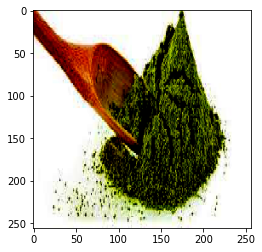

In [5]:
# Populate dataframe with (filename, label) pairs
df = build_dataframe(train_file_paths)

# Split dataset into training and testing data:
#    Pull a sample of size sample_fraction from the dataset.
#    Test set is test_size proportion of sample, training set is the rest.
train_df, test_df = train_test_split(df.sample(frac = sample_fraction), test_size=test_size, random_state=0)

# Create data generators and image sets.
train_generator,test_generator,train_images,val_images,test_images = generate_image_data()

# Confirmar el shape de los datos
print('\nImage Shape:')
for images, labels in train_images:
    print(images.shape, labels.shape)
    plt.imshow(images[0])
    break

In [6]:
# Using a Sequential model to build a stacked layer neural network.
# Each layer has one input tensor and one output tensor.
model = tf.keras.models.Sequential([
  
  # INPUT LAYER
  # Flattens the multi-dimensional image array into a 1-dimensional vector
  tf.keras.layers.Flatten(input_shape=(input_shape[0],input_shape[1],3)),
  
  # HIDDEN LAYERS:
  # This layer implements the output = activation(dot(input,kernel)+bias).
  #    kernel: una matriz de pesos creada por la capa..
  #    bias: a bias vector created by the layer.
    
  tf.keras.layers.Dense(512, activation='relu'),

  tf.keras.layers.Dense(256, activation='relu'),

  tf.keras.layers.Dense(128, activation='relu'),

  # La deserción representa un umbral en el que eliminamos algunas unidades al azar. 
  # En la última capa oculta, esto le da a cada unidad un 20% de probabilidad de ser eliminada.
  # en cada paso del entrenamiento.  Ayuda a prevenir el sobreajuste.
  tf.keras.layers.Dropout(dropout),
  
  # CAPA DE SALIDA: 
  # Aplique la función softmax aquí para satisfacer los requisitos de la función de pérdida.
  tf.keras.layers.Dense(2, activation='softmax')
])

# Muestra la forma y los parámetros del modelo
model.summary()

# Adam: Estimación del movimiento adaptativo
# Optimizador: por ejemplo, descenso de gradiente.  Determina la dirección y el alcance del cambio.
# Pérdida: estima la pérdida del sistema.  Se usa al entrenar el modelo.
# Métricas: juzga el desempeño del modelo (otros: probabilístico, regresión, T / F)
# Las métricas no se utilizan al entrenar el modelo.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               100663808 
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 100,828,290
Trainable params: 100,828,290
Non-trainable params: 0
__________________________________________

In [7]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='drive/MyDrive/BDC/mlp.model.best.hdf5', verbose=1, save_best_only=True)

In [ ]:
# Entrene el modelo sin datos de validación
#history = model.fit (train_images, epochs = epochs)

# Train the model with validation data
fit_history = model.fit(train_images, validation_data=val_images, epochs=epochs,callbacks=[checkpointer],verbose=1)

# Plot accuracy and losses for training set and validation set
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(fit_history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(fit_history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

Epoch 1/10
 79/113 [===================>..........] - ETA: 39:57 - loss: 10.9728 - accuracy: 0.6815

In [ ]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.image as img
 
longitud, altura = 256, 256
modelo = 'drive/MyDrive/BDC/mlp.model.best.hdf5'
cnn = load_model(modelo)
 
def predict(file):
 
  image = img.imread(file)
  plt.imshow(image, cmap=None)
  plt.show()
 
  x = load_img(file, target_size=(longitud, altura))
  x = img_to_array(x)
  x = np.expand_dims(x, axis=0)
  array = cnn.predict(x)
  result = array[0]
  
  answer = np.argmax(result)
  if answer == 0:
    print("Residuo: Organico")
  elif answer == 1:
    print("Residuo: Inorganico")
 
  return answer
 
predict('./drive/MyDrive/BDC/DATASET/UPLOADED/tom2.jpg')